In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold, LeaveOneGroupOut, StratifiedKFold
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
from sklearn.preprocessing import StandardScaler
import pickle
import seaborn as sns
from sklearn.metrics import r2_score

In [2]:
# dask cluster location
cluster_loc = 'local'
prefix = 'plot'
tuneby = 'year'

inDIR = '../data/training/'
inFILE = 'vor_2013_2022_cln_2023_08_29_' + prefix + '_hls_idxs.csv'

inPATH = os.path.join(inDIR, inFILE)

lr_mod = pickle.load(open("../models/biomass/CPER_HLS_to_VOR_biomass_model_lr_simp.pk", 'rb'))

outDIR = './results/'



var_names = ['dfi', 'ndvi', 'ndti', 'satvi', 'ndii7', 
             'savi', 'rdvi', 'mtvi1', 'nci', 'ndci', 'psri', 'ndwi', 'evi', 'tcbi', 'tcgi', 'tcwi',
             'blue', 'green', 'red', 'nir', 'swir1', 'swir2',
             'bai_126', 'bai_136', 'bai_146', 'bai_236', 'bai_246', 'bai_346']

var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'SAVI': 'savi',
    'RDVI': 'rdvi',
    'MTVI1': 'mtvi1', 
    'NCI': 'nci', 
    'NDCI': 'ndci',
    'PSRI': 'psri',
    'NDWI': 'ndwi',
    'EVI': 'evi',
    'TCBI': 'tcbi',
    'TCGI': 'tcgi',
    'TCWI': 'tcwi',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'BLUE': 'blue',
    'GREEN': 'green',
    'RED': 'red',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}

rand_st = 2313

In [3]:
if cluster_loc == 'hpc':
    from dask.distributed import LocalCluster, Client
    import dask_jobqueue as jq
    import dask
    from jupyter_server import serverapp
    # get the server address for porting
    try:
        jupServer = [x for x in serverapp.list_running_servers()][0]
    except IndexError:
        # manually copy/paste the server address
        jupServer = {'base_url': '/node/ceres19-compute-98-eth.scinet.local/17710/'}
    print('   setting up cluster on HPC...')
    dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
    partition='short',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 2.5*num_processes*num_threads_per_processes
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory=str(mem)+'GB',
                            #interface='ib0',
                            interface='ens7f0',
                            local_directory='$TMPDIR',
                            death_timeout=30,
                            walltime='02:00:00',
                            job_extra=["--output=/dev/null","--error=/dev/null"])
    client=Client(clust)
    #Scale Cluster 
    num_jobs=16
    clust.scale(jobs=num_jobs)
    try:
        client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
    except dask.distributed.TimeoutError as e:
        print(str(num_jobs*num_processes) + ' workers not available. Continuing with available workers.')
        #print(e)
        pass
    display(client)
    backend = 'dask'
else:
    backend = 'threading'

In [4]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def vip(x, y, model):
    t = model.x_scores_
    #w = model.x_weights_
    w = model.x_rotations_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

def r2_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    return R_sq

In [5]:
#df_results = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results.csv"))
#df_results_full = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results_full.csv"))

In [6]:
df_vor = pd.read_csv(inPATH, parse_dates=[2, 3])
if 'PRSI' in df_vor.columns:
    df_vor = df_vor.rename(columns={'PRSI': 'PSRI'})
df_vor = df_vor.rename(columns=var_dict)

In [7]:
df_vor = df_vor[df_vor['Season'].isin(['June', 'October'])].copy()
#df_vor = df_vor[df_vor['Year'] >= 2017].copy()

In [8]:
# check for any missing data
len(df_vor[df_vor[var_names].isnull().any(axis=1)])

0

In [9]:
# remove missing data
df_vor = df_vor[~df_vor[var_names].isnull().any(axis=1)].copy()
#df_vor = df_vor[~df_vor['Id'].isin(df_vor[df_vor[var_names].isnull().any(axis=1)]['Id'].unique())].copy()

In [10]:
X_vars_all = df_vor[var_names]
Y_var_all = df_vor['Biomass_kg_ha']

In [11]:
if False:
    corrMatrix = X_vars_all.reset_index(drop=True).join(Y_var_all.reset_index(drop=True)).corr()
    plt.figure(figsize=(14, 12))
    plt.suptitle('All')
    sns.heatmap(corrMatrix, annot=True)
    #plt.show()

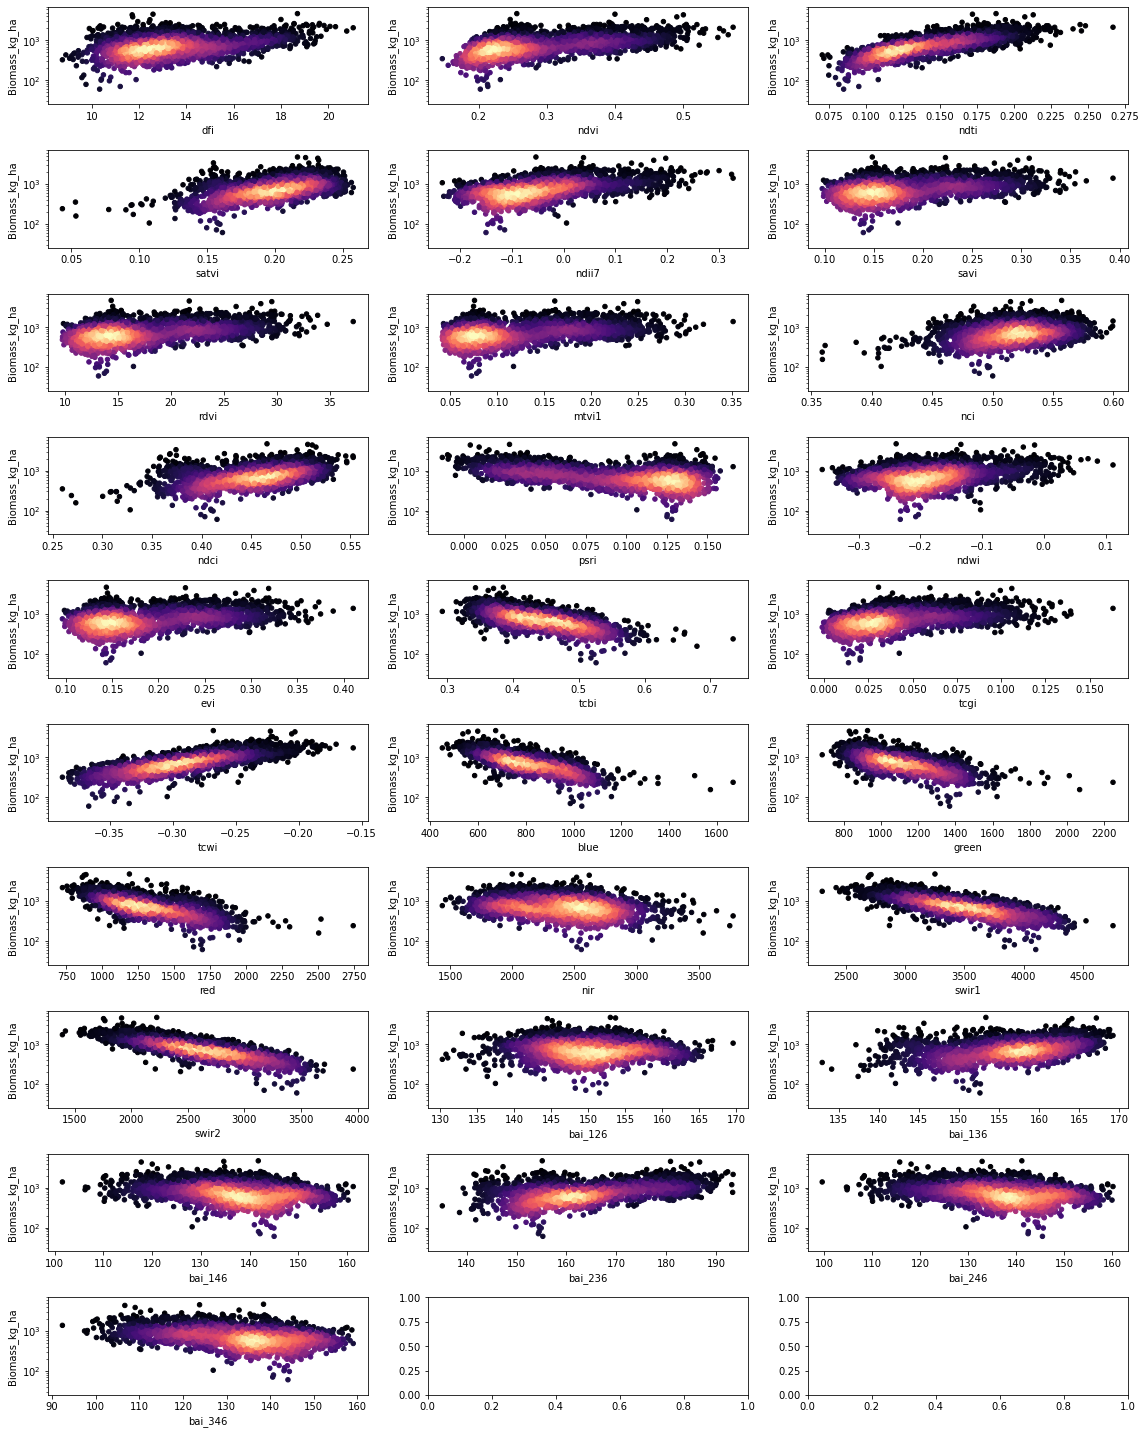

In [12]:
if True:
    fig, axs = plt.subplots(figsize=(16, 20),
                            nrows=int(np.ceil(len(var_names) / 3)), ncols=3)
    for idx, v in enumerate(var_names):
        xy_bm = np.vstack([df_vor[v], df_vor['Biomass_kg_ha']])
        z_bm = gaussian_kde(xy_bm)(xy_bm)
        df_vor.plot.scatter(x=v, y='Biomass_kg_ha', logy=True, ax=axs.flatten()[idx], ylim=(25, 7000),
                                c=z_bm, cmap='magma', colorbar=False)
        plt.tight_layout(pad=1.0)

In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

In [14]:
os.environ["PYTHONWARNINGS"] = 'ignore'# 'ignore::sklearn.exceptions.ConvergenceWarning:sklearn.model_selection.GridSearchCV'
import multiprocessing
multiprocessing.cpu_count()

72

In [15]:
scaler = StandardScaler()
mod_logo = LeaveOneGroupOut()
mod_groupk = GroupKFold(n_splits=10)
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error'}

In [16]:
from joblib import parallel_backend
import warnings
from sklearn.exceptions import ConvergenceWarning
import time
from sklearn.metrics import r2_score

In [22]:
mod_dict = {
    'LASSO': {
        'base_mod': Lasso(),
        'fit': True,
        'tune': True,
        'variable_importance': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'alpha': np.logspace(-3, 1, num=30)
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': True,
        'interactions': True,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'Coef'])
    },
    'PLS': {
        'base_mod': PLSRegression(n_components=1, scale=False),
        'fit': True,
        'tune': True,
        'tune_vip': False,
        'tune_vip_iters': 3,
        'tune_vip_thresh': [0.8, 0.8, 0.8],
        'variable_importance': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'n_components': np.arange(1, len(var_names))
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': True,
        'interactions': True,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'VIP', 'Coef'])
    },
    'PCR': {
        'base_mod': make_pipeline(PCA(), LinearRegression()),
        'fit': True,
        'tune': True,
        'variable_importance': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'pca__n_components': np.arange(1, len(var_names))
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': True,
        'interactions': True,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable'] + ['PC_' + str(i+1) for i in range(len(var_names))])
    },
    'SVR': {
        'base_mod': SVR(),
        'fit': True,
        'variable_importance': True,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'C': np.logspace(1.5, 4, 20, base=10),
            'gamma': np.logspace(-3.5, 0, 10, base=10)
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'PI'])
    },
    'RF': {
        'base_mod': RandomForestRegressor(n_estimators=500, random_state=rand_st),
        'fit': True,
        'tune': True,
        'variable_importance': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'min_samples_split': [0.001, 0.005, 0.01, 0.025, 0.05],
            'n_estimators': [200, 400],
            'max_samples': [0.2, 0.4, 0.6, 0.8, 0.9],
            'max_features': [None]
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'PI'])
    },
    'GBR': {
        'base_mod': XGBRegressor(n_jobs=1, verbosity=0),
        'fit': True,
        'variable_importance': True,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 6, 9],
            'min_child_weight': [10, 100, 200, 400],
            'n_estimators': [100, 200, 400]
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'PI'])
    }
}

In [ ]:
for k in mod_dict:
    if mod_dict[k]['fit']:
        df_vor[k] = np.nan

for train_index, test_index in mod_logo.split(X_vars_all, groups=df_vor['Date'].dt.year, ):
    yr = df_vor['Date'].dt.year.iloc[test_index].unique()[0]
    print("Running K-fold = " + str(yr))

    train_loc = df_vor.iloc[train_index].index
    test_loc = df_vor.iloc[test_index].index
    
    all_y_orig = Y_var_all.iloc[train_index]
    all_Y_orig = Y_var_all.iloc[test_index]
    all_x_orig = df_vor[var_names].iloc[train_index, :]
    all_X_orig = df_vor[var_names].iloc[test_index, :]

    for k in mod_dict:
        if mod_dict[k]['fit']:
            print('....fitting ' + k, end = " ")
            t0 = time.time()
            if mod_dict[k]['log_y']:
                all_y = np.log(1 + all_y_orig)
                all_Y = np.log(1 + all_Y_orig)
            else:
                all_y = all_y_orig.copy()
                all_Y = all_Y_orig.copy()
            if mod_dict[k]['scale_x']:
                scaler.fit(all_x_orig)
                all_x = scaler.transform(all_x_orig)
                all_X = scaler.transform(all_X_orig)
            else:
                all_x = all_x_orig.copy()
                all_X = all_X_orig.copy()
        
            if mod_dict[k]['interactions']:
                poly_x = PolynomialFeatures(degree=mod_dict[k]['interaction_poly'], 
                                            interaction_only=mod_dict[k]['interaction_only'], include_bias = False)
                all_x = poly_x.fit_transform(all_x)
                poly_X = PolynomialFeatures(degree=mod_dict[k]['interaction_poly'], 
                                            interaction_only=mod_dict[k]['interaction_only'], include_bias = False)
                all_X = poly_X.fit_transform(all_X)
                var_names_out = poly_x.get_feature_names_out(var_names)
            else:
                var_names_out = var_names

            # create a base model
            mod_base = mod_dict[k]['base_mod']
            
            if mod_dict[k]['tune']:
                if tuneby == 'year':
                    cv_splitter = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])
                elif tuneby == 'pasture':
                    cv_splitter = mod_groupk.split(all_x, groups=df_vor['Pasture'].iloc[train_index])
                grid_search = GridSearchCV(estimator=mod_base,
                                                   param_grid=mod_dict[k]['param_grid'],
                                                   scoring=scoring, 
                                                   refit=mod_dict[k]['tune_refit'], 
                                                   return_train_score=True,
                                                   cv=cv_splitter, 
                                                   n_jobs=-1, 
                                                   verbose=0)
                with parallel_backend(backend):
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=ConvergenceWarning)
                        grid_search.fit(all_x, all_y)
                mod_fnl = mod_base.set_params(**grid_search.best_params_)
                mod_fnl.fit(all_x, all_y)
                mod_dict[k]['tune_results'][yr] = grid_search.cv_results_
            else:
                mod_fnl = mod_base
                mod_fnl.fit(all_x, all_y)

            if mod_dict[k]['variable_importance']:
                if k == 'LASSO':
                    lasso_coefs = abs(mod_fnl.coef_)
                    var_names_out = [x for idx, x in enumerate(var_names_out) if abs(lasso_coefs[idx]) != 0.0]
                    lasso_coefs = lasso_coefs[abs(lasso_coefs) > 0.0]
                    mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                            pd.DataFrame({'Year': str(df_vor['Date'].dt.year.iloc[test_index].unique()[0]),
                                                                          'Variable': var_names_out,
                                                                          'Coef': lasso_coefs})])
                if k == 'PLS':
                    pls_vip = vip(all_x, all_y, mod_fnl)
                    pls_coefs = abs(mod_fnl.coef_).squeeze()
                    if mod_dict[k]['tune_vip']:
                        if len(mod_dict[k]['tune_vip_thresh']) != mod_dict[k]['tune_vip_iters']:
                            print('ERROR: Length of tune_vip_thresh does not equal tune_vip_iters.')
                            break
                        else:
                            for i in range(mod_dict[k]['tune_vip_iters']):
                                vip_thresh = mod_dict[k]['tune_vip_thresh'][i]
                                all_x = all_x[:, pls_vip > vip_thresh]
                                all_X = all_X[:, pls_vip > vip_thresh]
                                mod_fnl.fit(all_x, all_y)
                                var_names_out = [x for idx, x in enumerate(var_names_out) if pls_vip[idx] > vip_thresh]
                                pls_vip = vip(all_x, all_y, mod_fnl)
                                pls_coefs = abs(mod_fnl.coef_).squeeze()
                        
                    mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                            pd.DataFrame({'Year': str(df_vor['Date'].dt.year.iloc[test_index].unique()[0]),
                                                                          'Variable': var_names_out,
                                                                          'VIP': pls_vip,
                                                                          'Coef': pls_coefs})])
                if k == 'PCR':
                    # get distributed coefficients by multiplying variable loadings by PC coefficients
                    coefs = pd.DataFrame(mod_fnl['pca'].components_.T  * mod_fnl['linearregression'].coef_, 
                                            columns=['PC_' + str(i+1) for i in range(grid_search.best_params_['pca__n_components'])], 
                                            index=var_names_out).reset_index().rename(columns={'index': 'Variable'})
                    coefs['Year'] = str(df_vor['Date'].dt.year.iloc[test_index].unique()[0])
                    mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                            coefs])
                    
                if k in ['SVR', 'RF', 'GBR']:
                    rf_pi = permutation_importance(mod_fnl, all_X, all_Y, n_repeats=10, random_state=rand_st, n_jobs=-1)
                    mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                            pd.DataFrame({'Year': str(df_vor['Date'].dt.year.iloc[test_index].unique()[0]),
                                                                          'Variable': var_names_out,
                                                                          'PI': rf_pi.importances_mean})])
            
            if mod_dict[k]['log_y']:
                preds = np.exp(mod_fnl.predict(all_X).squeeze()) + 1
            else:
                preds = mod_fnl.predict(all_X).squeeze()
            df_vor.loc[test_loc, k] = preds
            print('(time to fit: ' + str(round(time.time() - t0, 2)) + ' secs)')
        else:
            continue

Running K-fold = 2013
....fitting LASSO (time to fit: 10.8 secs)
....fitting PLS (time to fit: 17.91 secs)
....fitting PCR (time to fit: 18.2 secs)
....fitting SVR 

In [ ]:
df_vor['Year'] = df_vor['Date'].dt.year
df_vor['Pasture'] = df_vor['Id'].apply(lambda x: x.split('_')[0])
df_vor['Plot'] = df_vor['Id'].apply(lambda x: x.split('_')[1])
if len(df_vor['Id'].iloc[0].split('_')) == 3:
    df_vor['Transect'] = df_vor['Id'].apply(lambda x: x.split('_')[-1])


In [ ]:
if 'Transect' in df_vor.columns:
    df_bm_pred = pd.melt(df_vor.drop(columns=['Low', 'High', 'geometry', 'Date'] + var_names).rename(columns={'Biomass_kg_ha': 'Observed'}), 
                         id_vars=['Id', 'Pasture', 'Year', 'Date_mean', 'Plot', 'Transect', 'Season', 'Observed'], 
                         value_name='Predicted',
                         var_name='Source')
else:
    df_bm_pred = pd.melt(df_vor.drop(columns=['Low', 'High', 'geometry', 'Date'] + var_names).rename(columns={'Biomass_kg_ha': 'Observed'}), 
                     id_vars=['Id', 'Pasture', 'Year', 'Date_mean', 'Plot', 'Season', 'Observed'], 
                     value_name='Predicted',
                     var_name='Source')
    

In [ ]:
df_bm_pred.to_csv('results/ml_pred_' + prefix + '_cv_year_tuneby_' + tuneby + '.csv', index=False)
with open('results/ml_train_' + prefix + '_cv_year_tuneby_' + tuneby + '_results.pk', 'wb') as fp:
    pickle.dump(mod_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
save_results=False

In [ ]:
df_bm_pred['Source'] = pd.Categorical(df_bm_pred['Source'], 
                                      categories=['LASSO', 'PLS', 'PCR', 'RF', 'SVR', 'GBR'])

In [ ]:
if 'Transect' in df_bm_pred.columns:
    mae_transect = df_bm_pred.groupby(['Source', 'Year']).apply(
        lambda z: z.groupby(['Pasture', 'Plot', 'Transect', 'Date_mean']).apply(
            lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
    mape_transect = df_bm_pred.groupby(['Source', 'Year']).apply(
        lambda z: z.groupby(['Pasture', 'Plot', 'Transect', 'Date_mean']).apply(
            lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
    r2_transect = df_bm_pred.groupby(['Source', 'Year']).apply((lambda x: r2_score(x['Observed'], x['Predicted']))).round(2)
    r2_corr_transect = df_bm_pred.groupby(['Source', 'Year']).apply((lambda x: r2_corrcoef(x['Observed'], x['Predicted']))).round(2)

In [ ]:
if 'Transect' in df_bm_pred.columns:
    df_smry_transect = pd.DataFrame({
        'MAE': mae_transect.unstack(level=0).mean().round(2),
        'MAPE': mape_transect.unstack(level=0).mean().round(2),
        'R^2': r2_transect.unstack(level=0).mean().round(2),
        'r^2': r2_corr_transect.unstack(level=0).mean().round(2)
    })
    display(df_smry_transect)
    if save_results:
        df_smry_transect.to_csv('results/tables/ml_models/ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby + '.csv')

    df_smry_transect_by_yr = pd.DataFrame({
        'MAE': mae_transect.round(2),
        'MAPE': mape_transect.round(2),
        'R^2': r2_transect.round(2),
        'r^2': r2_corr_transect.round(2)
    })
    #display(df_smry_plot_by_yr)
    if save_results:
        df_smry_transect_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv')

In [ ]:
mae_plot = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Plot', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_plot = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Plot', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
r2_plot = df_bm_pred.groupby(['Source', 'Year', 'Pasture', 'Plot']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    (lambda x: r2_score(x['Observed'], x['Predicted']))).round(2)
r2_corr_plot = df_bm_pred.groupby(['Source', 'Year', 'Pasture', 'Plot']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
        lambda x: r2_corrcoef(x['Observed'], x['Predicted'])).round(2)

In [ ]:
df_smry_plot = pd.DataFrame({
    'MAE': mae_plot.unstack(level=0).mean().round(2),
    'MAPE': mape_plot.unstack(level=0).mean().round(2),
    'R^2': r2_plot.unstack(level=0).mean().round(2),
    'r^2': r2_corr_plot.unstack(level=0).mean().round(2)
})
display(df_smry_plot)
if save_results:
    df_smry_plot.to_csv('results/tables/ml_models/ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '.csv')

df_smry_plot_by_yr = pd.DataFrame({
    'MAE': mae_plot.round(2),
    'MAPE': mape_plot.round(2),
    'R^2': r2_plot.round(2),
    'r^2': r2_corr_plot.round(2)
})
#display(df_smry_plot_by_yr)
if save_results:
    df_smry_plot_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv')

In [ ]:
mae_pasture = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_pasture = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
r2_pasture = df_bm_pred.groupby(['Source', 'Year', 'Pasture']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    lambda x: r2_score(x['Observed'], x['Predicted'])).round(2)
r2_corr_pasture = df_bm_pred.groupby(['Source', 'Year', 'Pasture']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    lambda x: r2_corrcoef(x['Observed'], x['Predicted'])).round(2)

In [ ]:
df_smry_pasture = pd.DataFrame({
    'MAE': mae_pasture.unstack(level=0).mean().round(2),
    'MAPE': mape_pasture.unstack(level=0).mean().round(3),
    'R^2': r2_pasture.unstack(level=0).mean().round(2),
    'r^2': r2_corr_pasture.unstack(level=0).mean().round(2)
})
display(df_smry_pasture)
if save_results:
    df_smry_pasture.to_csv('results/tables/ml_models/ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '.csv')

df_smry_pasture_by_yr = pd.DataFrame({
    'MAE': mae_pasture.round(2),
    'MAPE': mape_pasture.round(3),
    'R^2': r2_pasture.round(2),
    'r^2': r2_corr_pasture.round(2)
})
#display(df_smry_pasture_by_yr)
if save_results:
    df_smry_pasture_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv')

In [ ]:
df_vip = mod_dict['PLS']['variable_df']
p = sns.catplot(df_vip[df_vip['VIP'] > 1.0], x='Variable', y='VIP', hue='Year', aspect=3)
for ax in p.axes.flatten():
    ax.tick_params(axis='x', rotation=90)

In [ ]:
df_vip[df_vip['VIP'] > 1.0].groupby('Variable')['VIP'].count().sort_values(ascending=False)

In [ ]:
p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3, col_order=['LASSO', 'PLS', 'PCR', 'RF', 'SVR', 'GBR'],
               hue='Year', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)

In [ ]:
p_pasture = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, col_order=['LASSO', 'PLS', 'PCR', 'RF', 'SVR', 'GBR'], 
               hue='Year', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)

In [ ]:
df_lasso_coefs = mod_dict['LASSO']['variable_df']
df_lasso_coefs['Coef_abs'] = abs(df_lasso_coefs['Coef'])
p = sns.catplot(df_lasso_coefs, x='Variable', y='Coef_abs', hue='Year', aspect=3)
for ax in p.axes.flatten():
    ax.tick_params(axis='x', rotation=90)

In [ ]:
df_lasso_coefs.groupby('Variable')['Coef'].count().sort_values(ascending=False)

In [ ]:
df_pcr_coefs = mod_dict['PCR']['variable_df'].dropna(axis=1)

In [ ]:
pcr_coefs_abs_mean = df_pcr_coefs.groupby(['Year', 'Variable']).apply(lambda x: np.mean(np.abs(x), axis=1))
pcr_coefs_abs_mean.name = 'Coef_mean_abs'
df_pcr_coefs_mean = pcr_coefs_abs_mean.reset_index()

In [ ]:
pcr_vars_mean_ranked = df_pcr_coefs_mean.groupby('Variable')['Coef_mean_abs'].mean().sort_values(ascending=False)

In [ ]:
p = sns.catplot(df_pcr_coefs_mean[df_pcr_coefs_mean['Variable'].isin(pcr_vars_mean_ranked.head(20).index.values)], 
                x='Variable', y='Coef_mean_abs', hue='Year', aspect=3)
for ax in p.axes.flatten():
    ax.tick_params(axis='x', rotation=90)

In [ ]:
param_dfs = {}
for k in mod_dict:
    for idx, yr in enumerate(mod_dict[k]['tune_results']):
        if idx == 0:
            param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results'][yr]['params']]))
            param_dfs[k] = pd.DataFrame(columns=['Model', 'Year', 'Best', 'MAPE', 'MSE', 'R2', 'R2_train'] + param_names)
        df_tmp = pd.DataFrame({'Model': k,
                               'Year': yr,
                               'Best': 0,
                               'MAPE': mod_dict[k]['tune_results'][yr]['mean_test_MAPE'],
                               'MSE': mod_dict[k]['tune_results'][yr]['mean_test_MSE'],
                               'R2': mod_dict[k]['tune_results'][yr]['mean_test_R2'],
                               'R2_train': mod_dict[k]['tune_results'][yr]['mean_train_R2']})
        for p in param_names:
            df_tmp[p] = mod_dict[k]['tune_results'][yr]['param_' + p].data
        idx_best = mod_dict[k]['tune_results'][yr]['rank_test_MAPE'].argmin()
        df_tmp.loc[idx_best, 'Best'] = 1
        param_dfs[k] = pd.concat([param_dfs[k], df_tmp])

In [ ]:
sns.catplot(x='l1_ratio', y='MAPE', data=param_dfs['ElasticNet'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='pca__n_components', y='MAPE', data=param_dfs['PCR'], hue='Year', kind='point', aspect=2)